In [233]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps

try:
    # Tworzenie sesji Spark
    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()

    # Parametry połączenia z bazą danych MSSQL
    server_name = "mssql-server"
    port = "1433"
    database_name = "ETLKI"
    url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

    table_name = "ETLKI"
    username = "sa"
    password = "YourStrongPassword123"

    # Wczytanie danych z bazy danych MSSQL
    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

    print("Dane zostały pomyślnie wczytane z MSSQL.")
    # Wyświetlenie pierwszych kilku wierszy DataFrame


except Exception as e:
    print("Wystąpił błąd podczas łączenia z bazą danych:", str(e))



Dane zostały pomyślnie wczytane z MSSQL.


## Scenariusze/wskaźniki KPI

### 1. Pierwszy scenariusz 

Pierwszym krokiem w analizie danych jest przefiltrowanie przypadków, które spełniają określone kryteria. W tym konkretnym scenariuszu, analizujemy dane dotyczące przestępstw, koncentrując się na przypadkach, gdzie przestępcą jest mężczyzna, ofiarą jest kobieta, a przestępca ma pochodzenie etniczne Hiszpan lub Latynoska. Dodatkowo, ograniczamy się do przypadków, gdzie wiek przestępcy mieści się w przedziale od 18 do 35 lat.

Po przefiltrowaniu danych wg tych kryteriów, grupujemy liczbę przypadków, w których kobiety zostały zabite, w poszczególnych godzinach. Następnie obliczamy średnią liczbę zabitych kobiet dla każdej godziny, co pozwala nam zobaczyć, czy istnieją określone godziny, w których przestępstwa tego rodzaju są bardziej powszechne. Ten proces analizy pozwala nam lepiej zrozumieć wzorce przestępczości i identyfikować potencjalne obszary do dalszego monitorowania i interwencji

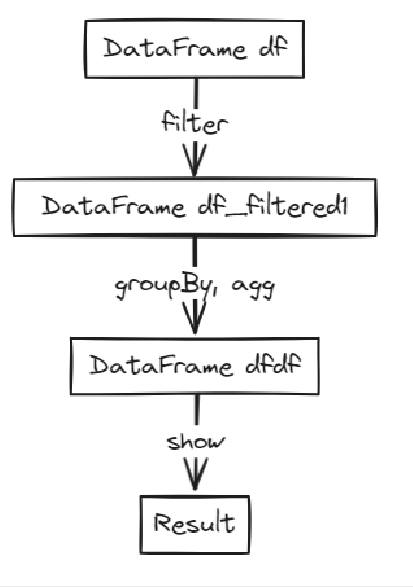

In [225]:
from IPython.display import Image
Image(filename='kpi1.png')


In [173]:
# Przefiltrowanie danych
df_filtered1 = df.filter(
    (col("gender of criminal") == "m") &
    (col("Vict Sex") == "Female") &
    (col("Vict Descent") == "Hispanic or Latino") &
    (col("age of criminal") == "18-35") 
)

kpi1 = df_filtered1.groupBy("Time").agg(avg("kill count").alias("Total Kill Count"))

kpi1.show()


+----+----------------+
|Time|Total Kill Count|
+----+----------------+
|  12|            0.25|
|  22|             3.5|
|   1|             0.0|
|  16|             0.0|
|   6|             0.0|
|   3|             0.0|
|  20|             0.0|
|   5|             2.0|
|  15|             0.0|
|  17|             0.0|
|   8|             0.0|
|   7|             1.5|
|  10|             1.0|
|  21|             0.5|
|  11|             5.0|
|  14|             5.0|
|   2|             1.0|
|   0|             0.0|
|  18|             1.2|
+----+----------------+



In [174]:
# Dołączenie kolumny "kill count" do ramki df na podstawie kolumny "Time"
df_with_kill_count_kpi1 = df.join(kpi1, "Time", "left")


### 2. Drugi scenariusz

Chcemy przeprowadzic analizę ilości osób bez wyższego wykształcenia, które biorą mocne narkotyki oraz popełniają przetępstwa w Hollywood

In [187]:
# Przefiltrowanie danych
df_filtered2 = df.filter(
    (col("AREA NAME") == "Hollywood") &
    (col("education levels") != "Higher education") &
    (col("drug substances") != "Alcohol") &
    (col("annual earnings") >= 100000) 
)



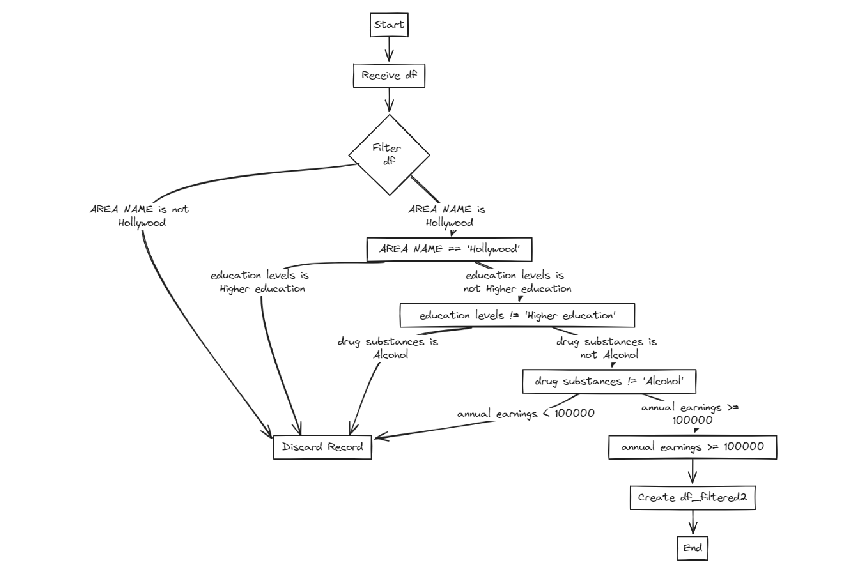

In [224]:
from IPython.display import Image
Image(filename='kpi2.png')

### 3. Trzeci scenariusz 

Średni wiek osób w poszczególnych dystryktach (AREA NAME) oraz średnie zarobki ofiar

In [238]:
from pyspark.sql import functions as F

# Grupowanie po AREA NAME i obliczanie średnich dla Vict Age i annual earnings
average_age_and_earnings_by_area = df.groupBy("AREA NAME").agg(
    F.avg("Vict Age").alias("Average Vict Age"),
    F.avg("annual earnings").alias("Average Vict Earnings")
)

average_age_and_earnings_by_area.show()


+-----------+------------------+---------------------+
|  AREA NAME|  Average Vict Age|Average Vict Earnings|
+-----------+------------------+---------------------+
|  Hollywood| 28.47222222222222|    94930.86111111111|
|     Harbor|29.233333333333334|    67767.23333333334|
| Devonshire| 37.78260869565217|    84374.86956521739|
|N Hollywood|35.107142857142854|    91556.64285714286|
|     Newton| 36.89473684210526|    90757.52631578948|
|   Van Nuys|           40.9375|          91033.21875|
|West Valley| 39.91428571428571|    85885.25714285714|
|    Mission| 30.73076923076923|    95515.53846153847|
|  Southeast| 34.71052631578947|    82481.18421052632|
|   Wilshire|29.566666666666666|    85049.56666666667|
|    Topanga| 41.02777777777778|    85690.91666666667|
|    Central| 36.38636363636363|    76694.18181818182|
|    Pacific| 36.26829268292683|     86761.9512195122|
| Hollenbeck|             35.52|              94969.6|
|    Olympic| 33.57575757575758|    82000.51515151515|
|  Southwe

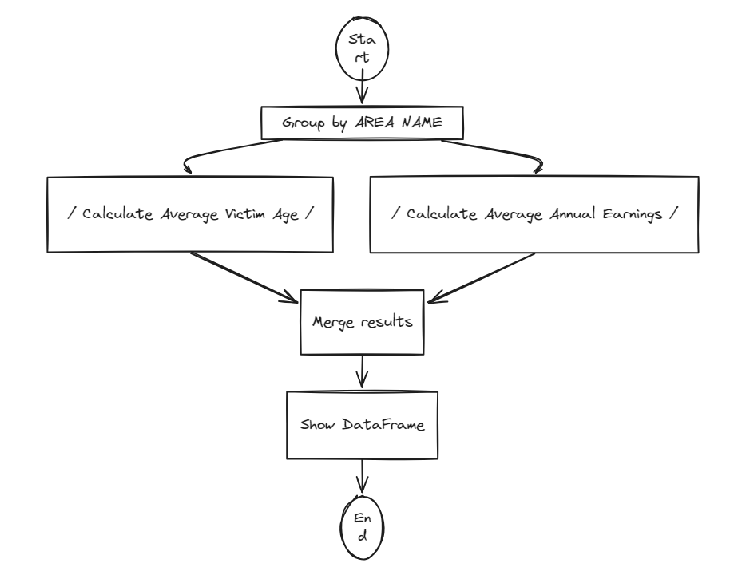

In [239]:
from IPython.display import Image
Image(filename='kpi3.png')

### 4. Czwarty scenariusz 